In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict
import pathlib

import numpy as np
import pandas as pd
import torch
import torchinfo
import scipy.stats
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.size"] = 7
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.grid'] = True

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore', FutureWarning)

In [3]:
samples_path = pathlib.Path("../samples/tsdr_anomaly_patterns/labeled_tsdr_anomaly_patterns_20221202-024759_fixed.jsonl")
samples_df: pd.DataFrame = pd.read_json(str(samples_path), orient='records', lines=True)
display(samples_df.groupby(["anomaly_pattern", "anomaly_position"]).size().sort_values(ascending=False))
samples_df.describe()

anomaly_pattern             anomaly_position     
White noise                 no_anomaly               267
Other normal                no_anomaly               127
Level shift down            anomaly_during_fault      99
Single spike                anomaly_during_fault      71
                            anomaly_outside_fault     62
Level shift up              anomaly_during_fault      62
Level shift down            anomaly_outside_fault     56
Transient level shift down  anomaly_during_fault      53
Steady decrease             anomaly_during_fault      49
Level shift up              anomaly_outside_fault     42
Transient level shift up    anomaly_during_fault      40
Steady increase             anomaly_during_fault      39
Multiple spikes             anomaly_outside_fault     38
Fluctuations                anomaly_during_fault      38
Single dip                  anomaly_during_fault      37
Transient level shift up    anomaly_outside_fault     28
Multiple dips               anomaly_ou

,dataset_id,target_app,chaos_type,chaos_comp,metric,time_series,anomaly_pattern,anomaly_position
count,1198,1198,1198,1198,1198,1198,1198,1198
unique,1,1,3,10,824,1177,15,3
top,qknmc,sock-shop,pod-memory-hog,catalogue,n-gke-meltria-sockshop-01-default-pool-cf9d09e...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",White noise,anomaly_during_fault
freq,1198,1198,524,202,7,3,267,524


In [4]:
tss = np.array([item for item in samples_df.loc[:, "time_series"].sample(n=10).reset_index(drop=True)])
random_sampled_df = pd.DataFrame(tss).T
random_sampled_df

,0,1,2,3,4,5,6,7,8,9
0,1.0,0.0000,0.0302,169253.3333,0.0007,557056.0,292052992.0,2.260314e+10,5202856.0,9.559191e+10
1,1.0,0.0000,0.0308,162154.3111,0.0007,557056.0,292052992.0,2.260325e+10,5202856.0,9.559189e+10
2,1.0,0.0000,0.0303,158230.7556,0.0007,589824.0,292057088.0,2.260332e+10,5202856.0,9.559185e+10
3,1.0,0.0000,0.0305,190979.5556,0.0007,753664.0,292057088.0,2.260386e+10,5202856.0,9.559176e+10
4,1.0,0.0000,0.0305,208435.2000,0.0007,720896.0,292077568.0,2.260396e+10,5202856.0,9.559174e+10
...,...,...,...,...,...,...,...,...,...,...
175,1.0,0.0000,0.0118,193630.7556,0.0000,655360.0,297414656.0,2.262740e+10,5202856.0,9.558596e+10
176,1.0,0.0000,0.0214,185075.7333,0.0000,622592.0,297390080.0,2.262750e+10,5235624.0,9.558594e+10
177,1.0,0.0000,0.0269,163394.6667,0.0000,589824.0,297418752.0,2.262758e+10,5202856.0,9.558592e+10
178,1.0,6.6667,0.0279,142330.4889,0.0000,589824.0,297390080.0,2.262775e+10,5202856.0,9.558589e+10


array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

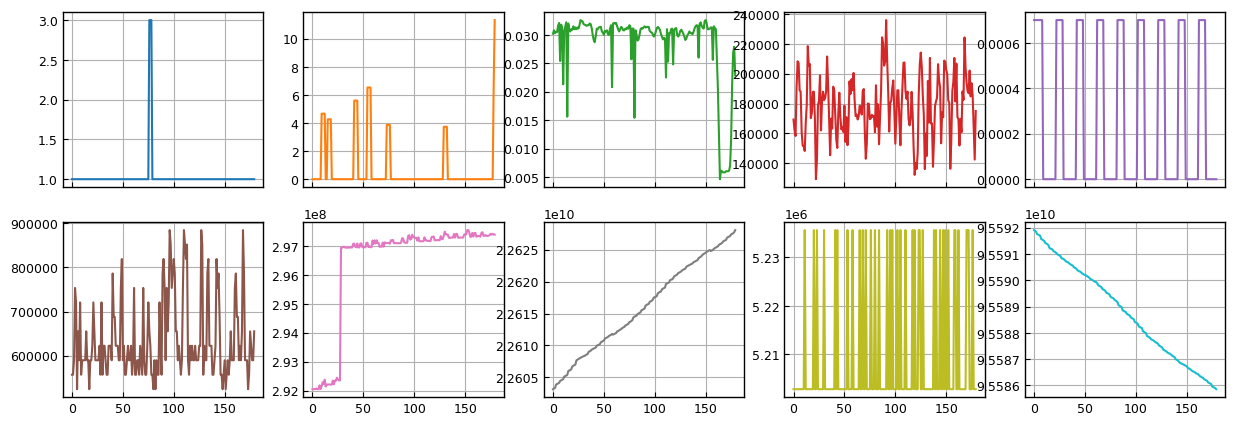

In [5]:
random_sampled_df.plot(figsize=(15, 5), legend=False, subplots=True, layout=(2, 5))

array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

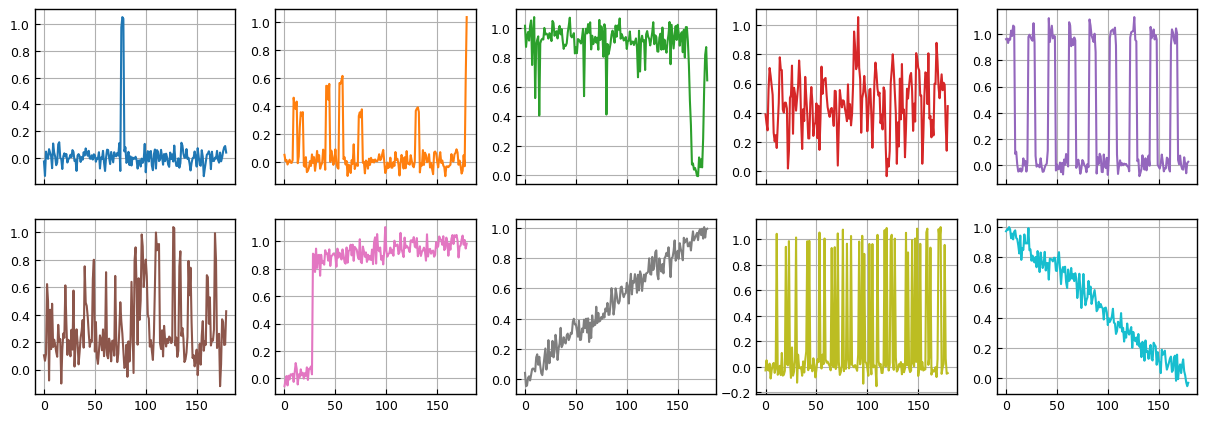

In [6]:
def add_noise(x, mu=.0, std=.05):
    # min/max normalization
    min, max = x.min(), x.max()
    nz_x = (x-min)/(max-min)
    noise = np.random.normal(mu, std, size = nz_x.shape)
    return nz_x + noise
    
random_sampled_df.apply(add_noise).reset_index(drop=True).plot(figsize=(15, 5), legend=False, subplots=True, layout=(2, 5))

## Reverse

array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

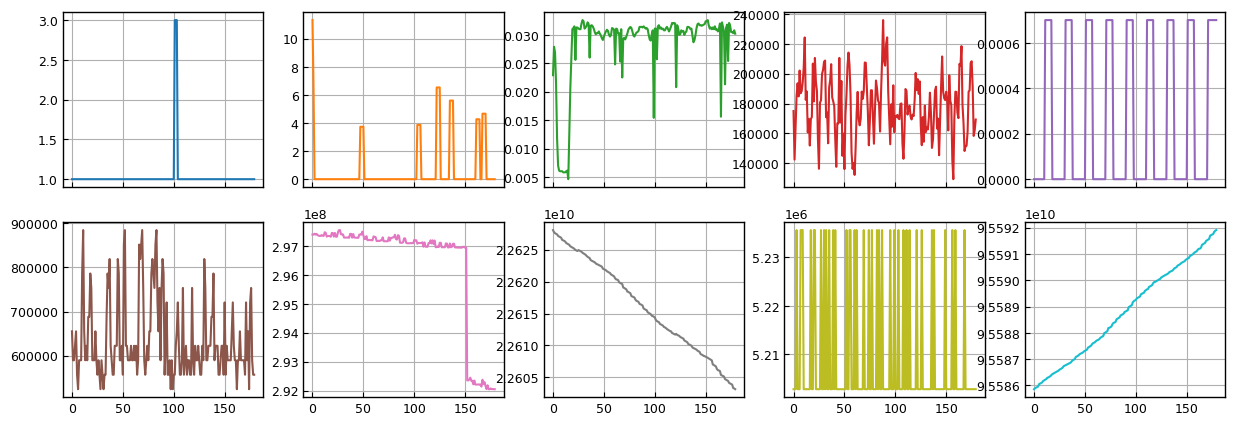

In [7]:
## horizontal reverse
random_sampled_df.apply(lambda x: x[::-1]).reset_index(drop=True).plot(figsize=(15, 5), legend=False, subplots=True, layout=(2, 5))

array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

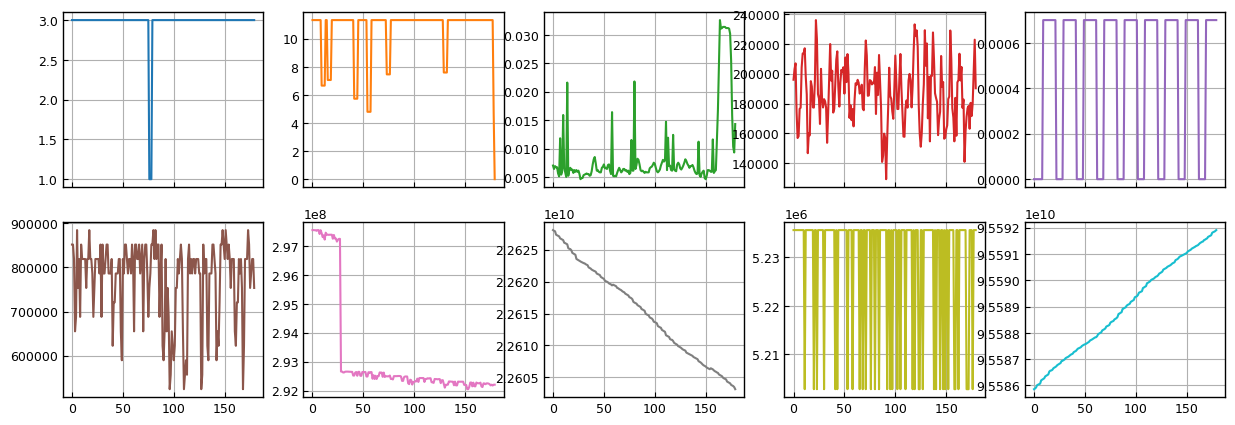

In [8]:
## vertical reverse
def flip_vertically(x):
    center = (np.max(x) + np.min(x))/2 
    _x = np.full_like(x, 0.0)
    for i in range(len(x)):
        _x[i] = center - (x[i] - center)
    return _x
    
random_sampled_df.apply(flip_vertically).reset_index(drop=True).plot(figsize=(15, 5), legend=False, subplots=True, layout=(2, 5))

## Shift

array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

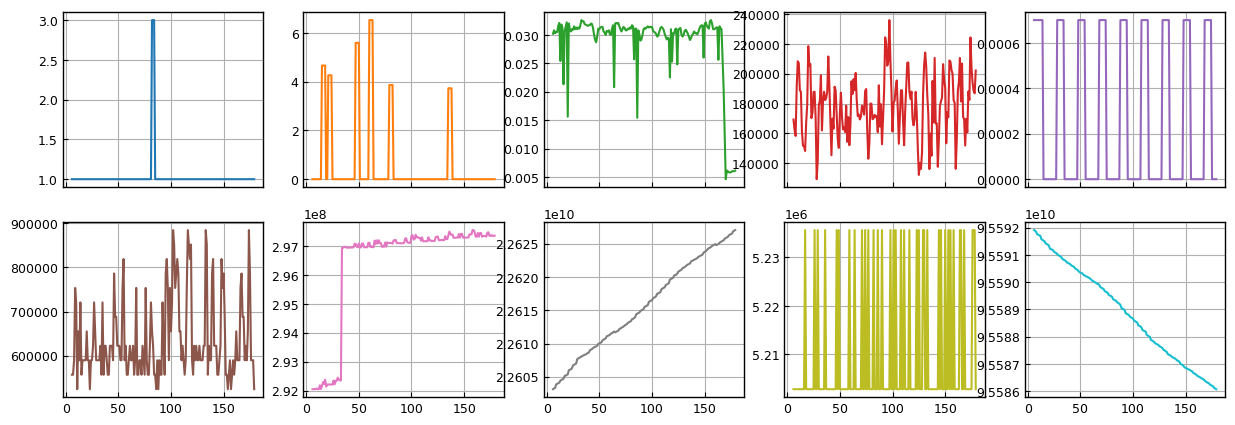

In [9]:
random_sampled_df.shift(6, axis=0).reset_index(drop=True).plot(figsize=(15, 5), legend=False, subplots=True, layout=(2, 5))

## Augumenting samples

rules / without anomaly position

1. Add noise -> no change of patterns
2. Reverse
   1. horizontal reverse
      1. Level shift up <-> Level shift down
      2. Steady increase <-> Steady decrease
      3. Sudden increase -> Sudden decrease
   2. vertical reverse
      1. Level shift up <-> Level shift down
      2. Steady increase <-> Steady decrease
      3. Sudden increase <-> Sudden decrease
      4. Single spike <-> Single dip
      5. Multiple spikes <-> Multiple dips
      6. Transient level shift up <-> Transient level shift down
3. Shift -> change anomaly position

In [10]:
samples_df["DA/noise"] = False
samples_df["DA/va_reverse"] = False
samples_df["DA/ha_reverse"] = False

In [11]:
## noise
noisy_samples_df = samples_df.copy()
noisy_samples_df.drop(columns="anomaly_position", inplace=True)
noisy_samples_df["time_series"] = noisy_samples_df.apply(lambda x: add_noise(np.array(x.time_series), mu=.0, std=.05), axis=1)
noisy_samples_df["DA/noise"] = True
noisy_samples_df.shape

(1198, 10)

In [12]:
## horizontal reverse
ha_reversed_samples_df = samples_df.copy()
ha_reversed_samples_df.drop(columns="anomaly_position", inplace=True)
ha_reversed_samples_df["time_series"] = ha_reversed_samples_df.apply(lambda x: np.array(x.time_series)[::-1], axis=1)

def relabel_anomaly_pattern_for_ha_reverse(cur_pattern):
    new_pattern: str
    match cur_pattern:
        case "Level shift up":
            new_pattern = "Level shift down"
        case "Level shift down":
            new_pattern = "Level shift up"
        case "Steady increase":
            new_pattern = "Steady decrease"
        case "Steady decrease":
            new_pattern = "Steady increase"
        case "Sudden increase":
            new_pattern = "Level shift down"  # not "Sudden decrease"
        case "Sudden decrease":
            new_pattern = "Level shift up"  # not "Sudden increase"
        case _:
            new_pattern = cur_pattern
    return new_pattern

ha_reversed_samples_df["anomaly_pattern"] = ha_reversed_samples_df["anomaly_pattern"].apply(relabel_anomaly_pattern_for_ha_reverse)
ha_reversed_samples_df["DA/ha_reverse"] = True
ha_reversed_samples_df.shape

(1198, 10)

In [13]:
## vertically reverse
va_reversed_samples_df = samples_df.copy()
va_reversed_samples_df.drop(columns="anomaly_position", inplace=True)
va_reversed_samples_df["time_series"] = va_reversed_samples_df.apply(lambda x: flip_vertically(np.array(x.time_series)), axis=1)

def relabel_anomaly_pattern_for_va_reverse(cur_pattern):
    new_pattern: str
    match cur_pattern:
        case "Level shift up":
            new_pattern = "Level shift down"
        case "Level shift down":
            new_pattern = "Level shift up"
        case "Steady increase":
            new_pattern = "Steady decrease"
        case "Steady decrease":
            new_pattern = "Steady increase"
        case "Sudden increase":
            new_pattern = "Sudden decrease"
        case "Sudden decrease":
            new_pattern = "Sudden increase"
        case "Single spike":
            new_pattern = "Single dip"
        case "Single dip":
            new_pattern = "Single spike"
        case "Multiple spikes":
            new_pattern = "Multiple dips"
        case "Multiple dips":
            new_pattern = "Multiple spikes"
        case "Transient level shift up":
            new_pattern = "Transient level shift down"
        case "Transient level shift down":
            new_pattern = "Transient level shift up"
        case _:
            new_pattern = cur_pattern
    return new_pattern

va_reversed_samples_df["anomaly_pattern"] = va_reversed_samples_df["anomaly_pattern"].apply(relabel_anomaly_pattern_for_va_reverse)
va_reversed_samples_df["DA/va_reverse"] = True
va_reversed_samples_df.shape

(1198, 10)

In [14]:
## noise + horizontal reverse
noisy_ha_reversed_samples_df = ha_reversed_samples_df.copy()
noisy_ha_reversed_samples_df["time_series"] = noisy_ha_reversed_samples_df.apply(lambda x: add_noise(np.array(x.time_series), mu=.0, std=.05), axis=1)
noisy_ha_reversed_samples_df["DA/noise"] = True
## noise + vertical reverse
noisy_va_reversed_samples_df = va_reversed_samples_df.copy()
noisy_va_reversed_samples_df["time_series"] = noisy_va_reversed_samples_df.apply(lambda x: add_noise(np.array(x.time_series), mu=.0, std=.05), axis=1)
noisy_va_reversed_samples_df["DA/noise"] = True

In [15]:
## save dataframe
all_df_with_da = pd.concat([samples_df, noisy_samples_df, ha_reversed_samples_df, va_reversed_samples_df, noisy_ha_reversed_samples_df, noisy_va_reversed_samples_df], ignore_index=True)
all_df_with_da.to_parquet("../samples/tsdr_anomaly_patterns_with_da/labeled_tsdr_anomaly_patterns_20221202-024759_with_da.parquet", index=False)
all_df_with_da.shape

(7188, 11)

## With anomaly position labels

- Adding noise (no change)
- Reverse
  - Vertical reverse (no change)
  - Horizontal reverse (no change)
    - anomaly_duaring_fault -> anomaly_outside_fault (OK)
    - anomaly_outside_fault -> anomaly_duaring_fault (NG)

In [16]:
## noise
noisy_samples_df_with_ap = samples_df.copy()
noisy_samples_df_with_ap["time_series"] = noisy_samples_df_with_ap.apply(lambda x: add_noise(np.array(x.time_series), mu=.0, std=.05), axis=1)
noisy_samples_df_with_ap["DA/noise"] = True
print("noisy", noisy_samples_df_with_ap.shape)

## horizontal reverse
ha_reversed_samples_df_with_ap = samples_df.query("anomaly_position == 'anomaly_during_fault'").copy()
ha_reversed_samples_df_with_ap["time_series"] = ha_reversed_samples_df_with_ap.apply(lambda x: np.array(x.time_series)[::-1], axis=1)
ha_reversed_samples_df_with_ap["anomaly_pattern"] = ha_reversed_samples_df_with_ap["anomaly_pattern"].apply(relabel_anomaly_pattern_for_ha_reverse)
ha_reversed_samples_df_with_ap["anomaly_position"] = "anomaly_outside_fault"
ha_reversed_samples_df_with_ap["DA/ha_reverse"] = True
print("ha_reverse", ha_reversed_samples_df_with_ap.shape)

## vertically reverse
va_reversed_samples_df_with_ap = samples_df.copy()
va_reversed_samples_df_with_ap["time_series"] = va_reversed_samples_df.apply(lambda x: flip_vertically(np.array(x.time_series)), axis=1)
va_reversed_samples_df_with_ap["anomaly_pattern"] = va_reversed_samples_df["anomaly_pattern"].apply(relabel_anomaly_pattern_for_va_reverse)
va_reversed_samples_df_with_ap["DA/va_reverse"] = True
print("va_reverse", va_reversed_samples_df_with_ap.shape)

## noise + horizontal reverse
noisy_ha_reversed_samples_df_with_ap = ha_reversed_samples_df_with_ap.copy()
noisy_ha_reversed_samples_df_with_ap["time_series"] = noisy_ha_reversed_samples_df_with_ap.apply(lambda x: add_noise(np.array(x.time_series), mu=.0, std=.05), axis=1)
noisy_ha_reversed_samples_df_with_ap["DA/noise"] = True
## noise + vertical reverse
noisy_va_reversed_samples_df_with_ap = va_reversed_samples_df_with_ap.copy()
noisy_va_reversed_samples_df_with_ap["time_series"] = noisy_va_reversed_samples_df_with_ap.apply(lambda x: add_noise(np.array(x.time_series), mu=.0, std=.05), axis=1)
noisy_va_reversed_samples_df_with_ap["DA/noise"] = True

noisy (1198, 11)
ha_reverse (524, 11)
va_reverse (1198, 11)


In [17]:
## save dataframe
all_df_with_da_with_ap = pd.concat([samples_df, noisy_samples_df_with_ap, ha_reversed_samples_df_with_ap, va_reversed_samples_df_with_ap, noisy_ha_reversed_samples_df_with_ap, noisy_va_reversed_samples_df_with_ap], ignore_index=True)
all_df_with_da_with_ap.to_parquet("../samples/tsdr_anomaly_patterns_with_da/labeled_tsdr_anomaly_patterns_20221202-024759_with_da_with_anomaly_position.parquet", index=False)
print(all_df_with_da_with_ap.shape)
all_df_with_da_with_ap.groupby(["anomaly_pattern", "anomaly_position"]).size().sort_values(ascending=False)

(5840, 11)


anomaly_pattern             anomaly_position     
White noise                 no_anomaly               1068
Other normal                no_anomaly                508
Level shift down            anomaly_outside_fault     400
                            anomaly_during_fault      396
Single spike                anomaly_outside_fault     390
Level shift up              anomaly_outside_fault     378
Single spike                anomaly_during_fault      284
Level shift up              anomaly_during_fault      248
Transient level shift down  anomaly_during_fault      212
Steady decrease             anomaly_during_fault      196
Transient level shift up    anomaly_outside_fault     192
                            anomaly_during_fault      160
Multiple spikes             anomaly_outside_fault     160
Steady increase             anomaly_during_fault      156
Fluctuations                anomaly_during_fault      152
Single dip                  anomaly_during_fault      148
Transient level shift 

In [18]:
for ts in all_df_with_da_with_ap.query("anomaly_pattern == 'Sudden decrease' and anomaly_position == 'anomaly_outside_fault'").itertuples():
    plt.plot(ts.time_series)
    plt.show()